<a href="https://colab.research.google.com/github/Roua91/Reaserch_Project/blob/main/Q1_Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Importing necessary libraries

In [ ]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install tensorflow-quantum
!pip install pennylane

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement tensorflow-quantum (from versions: none)
ERROR: No matching distribution found for tensorflow-quantum
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 18.2 MB/s eta 0:00:00


# 2- Importing and preprocessing the dataset

In [ ]:


import os

os.environ['KAGGLE_USERNAME'] = 'rouaalemam'
os.environ['KAGGLE_KEY'] = 'd16ffbf0d8bee8e95a525fdbfa328074'


In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 94% 184M/195M [00:01<00:00, 148MB/s]
100% 195M/195M [00:01<00:00, 143MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/breast-ultrasound-images-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()  # This line is indented
print('Done')

Done


In [ ]:
import os

# Path to the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

import shutil


# Path to the 'normal' directory
normal_dir_path = '/content/Dataset_BUSI_with_GT/normal'

# Check if the directory exists
if os.path.exists(normal_dir_path) and os.path.isdir(normal_dir_path):
    # Remove the 'normal' directory and all its contents
    shutil.rmtree(normal_dir_path)
    print(f"'{normal_dir_path}' has been removed.")
else:
    print(f"The directory '{normal_dir_path}' does not exist or is not a directory.")

all_files = os.listdir(dataset_dir)
print(all_files)



'/content/Dataset_BUSI_with_GT/normal' has been removed.
['benign', 'malignant']


In [ ]:
from PIL import Image
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Overlay and preparation code
dataset_dir = '/content/Dataset_BUSI_with_GT'  # Original dataset directory
overlay_dir = '/content/OverlayOutput'  # Directory to save overlayed images
labels = ['benign', 'malignant']

# Ensure the overlay output directory exists
os.makedirs(overlay_dir, exist_ok=True)
# Create subdirectories for each label in the overlay directory
for label in labels:
    os.makedirs(os.path.join(overlay_dir, label), exist_ok=True)


def overlay_and_save(image_path, mask_path, output_dir):
    try:
        # Construct the full path where the overlayed image will be saved
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # Check if the overlay image already exists
        if os.path.isfile(output_path):
            print(f"Overlay image already exists: {output_path}, skipping.")
            return  # Skip saving this image

        # Proceed if the overlay does not exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB
            mask = Image.open(mask_path).convert("L")      # Ensure mask is in grayscale

            mask = mask.resize(image.size)  # Resize mask to match image size

            # Create an RGBA version of the mask to use as overlay
            rgba_mask = Image.new("RGBA", mask.size, (255, 0, 0, 0))  # Red mask with zero opacity
            rgba_mask.putalpha(mask)  # Set alpha channel to mask values

            overlayed = Image.alpha_composite(image.convert("RGBA"), rgba_mask)

            # Save the overlayed image
            overlayed.convert("RGB").save(output_path)  # Convert back to RGB to save
            print(f"Saved overlayed image to: {output_path}")
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Perform overlay and save for each image in the dataset
for label in labels:
    image_dir = os.path.join(dataset_dir, label)
    output_label_dir = os.path.join(overlay_dir, label)
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith('.png'):
            image_path = os.path.join(image_dir, image_filename)
            mask_path = image_path.replace('.png', '_mask.png')
            overlay_and_save(image_path, mask_path, output_label_dir)

print("Overlayed images have been saved to the overlay directory.")

# Now proceed with loading and transforming the overlayed dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(15, expand=False, center=None),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the overlayed dataset
overlayed_dataset = datasets.ImageFolder(root=overlay_dir, transform=transform)

# Splitting dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(overlayed_dataset)), test_size=0.2, random_state=42)

# Creating data loaders
train_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
test_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(test_idx))

dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_idx), 'test': len(test_idx)}
class_names = overlayed_dataset.classes

print(f"Dataset split complete: {len(train_loader)} training batches, {len(test_loader)} testing batches.")

Saved overlayed image to: /content/OverlayOutput/benign/benign (206).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (388).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (146).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (33).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (334).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (123).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (34).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (307).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (311).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (285).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (212).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (132).png
Saved overlayed image to: /content/OverlayOutput/benign/benign (339).png
Saved overlayed image to: /content/OverlayOutput/beni

# 3- Quatum Circuit

In [ ]:
import time
n_qubits = 8               # Number of qubits
step = 0.00041             # Learning rate
batch_size = 5              # Number of samples for each training step
num_epochs = 30           # Number of training epochs
q_depth = 1                # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
import pennylane as qml

# Define your device
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the H_layer and RY_layer functions here
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

# Now you can define your quantum_net function
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
import torch.nn as nn
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# 4- Hybrid Classical Quantum Model

In [ ]:
import torchvision
model_hybrid = torchvision.models.resnet50(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


# 5- Training and Result

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
import torch.optim as optim
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
import torch
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')  # Initialize with a large number

    print("Training started:")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and test phase for evaluation
        for phase in ['train', 'test']:  # Use 'test' instead of 'validation'
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'Train' if phase == 'train' else 'Test',
                epoch_loss, epoch_acc))

            # Deep copy the model if we get the best accuracy on the test set
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test loss: {:.4f} Acc: {:.4f}'.format(best_loss, best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_hybrid = train_model(
    model_hybrid,
    criterion,
    optimizer_hybrid,
    exp_lr_scheduler,
    num_epochs=num_epochs,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device
)

Training started:
Epoch 1/30
----------
Train Loss: 0.5748 Acc: 0.7447
Test Loss: 0.4139 Acc: 0.8538
Epoch 2/30
----------
Train Loss: 0.4018 Acc: 0.8704
Test Loss: 0.3414 Acc: 0.8769
Epoch 3/30
----------
Train Loss: 0.3835 Acc: 0.8530
Test Loss: 0.2601 Acc: 0.9462
Epoch 4/30
----------
Train Loss: 0.2973 Acc: 0.9168
Test Loss: 0.2409 Acc: 0.9462
Epoch 5/30
----------
Train Loss: 0.2619 Acc: 0.9304
Test Loss: 0.2368 Acc: 0.9538
Epoch 6/30
----------
Train Loss: 0.2405 Acc: 0.9323
Test Loss: 0.2406 Acc: 0.9385
Epoch 7/30
----------
Train Loss: 0.2455 Acc: 0.9304
Test Loss: 0.2186 Acc: 0.9385
Epoch 8/30
----------
Train Loss: 0.2178 Acc: 0.9362
Test Loss: 0.1825 Acc: 0.9692
Epoch 9/30
----------
Train Loss: 0.2290 Acc: 0.9246
Test Loss: 0.1662 Acc: 0.9615
Epoch 10/30
----------
Train Loss: 0.2434 Acc: 0.9207
Test Loss: 0.2758 Acc: 0.8846
Epoch 11/30
----------
Train Loss: 0.3130 Acc: 0.8723
Test Loss: 0.1671 Acc: 0.9538
Epoch 12/30
----------
Train Loss: 0.2134 Acc: 0.9304
Test Loss: 0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mean and standard deviation used for ImageNet dataset normalization
# These values may need to be adjusted based on your dataset's normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def imshow(inp, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert tensor to (HxWxC) from (CxHxW)
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] range
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=6, fig_name="Predictions", num_cols=2):
    images_so_far = 0
    fig = plt.figure(fig_name, figsize=(10, num_images * 2))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = plt.subplot(num_images // num_cols + num_images % num_cols, num_cols, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}', fontsize=9)

                    # imshow function needs to be defined or use plt.imshow after converting tensor to numpy
                    imshow(inputs.cpu().data[j])
                else:
                    plt.tight_layout()
                    return
        plt.tight_layout()

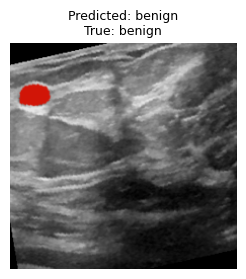

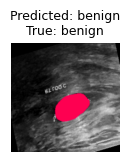

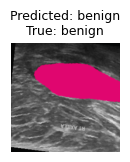

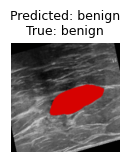

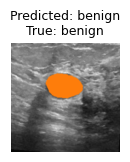

<Figure size 640x480 with 0 Axes>

In [ ]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# 6- Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch

def evaluate_model(model, dataloaders, device):
    model.eval()  # Set the model to evaluation mode
    true_labels_list, predictions_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels_list.extend(labels.cpu().numpy())
            predictions_list.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels_list, predictions_list)
    precision = precision_score(true_labels_list, predictions_list, average='binary')
    recall = recall_score(true_labels_list, predictions_list, average='binary')
    f1 = f1_score(true_labels_list, predictions_list, average='binary')
    # For AUC-ROC, you need model outputs as probabilities. This example assumes binary classification.
    # If your model outputs logits, convert these to probabilities using a softmax layer first.
    # auc_roc = roc_auc_score(true_labels_list, prediction_probabilities)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    # print(f'AUC-ROC: {auc_roc:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(true_labels_list, predictions_list)
    print("Confusion Matrix:")
    print(cm)

In [ ]:
evaluate_model(model_hybrid, dataloaders, device)

Accuracy: 0.9615
Precision: 0.9722
Recall: 0.8974
F1 Score: 0.9333
Confusion Matrix:
[[90  1]
 [ 4 35]]
